# **Medical Image Classification with PyTorch**


In this notebook we'll create an algorithm using deep learning and computer vision to identify metastatic cancer in small image patches taken from larger digital pathology scans.

<center> <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0W5QEN/images/cancer%20cell.jpeg" width="30%" alt="Restart kernel"> </center>

### Installing Required Libraries


In [1]:
! pip install --upgrade torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 113.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170

In [2]:
from torch.cuda import is_available, get_device_name

if is_available():
    print(f"The environment has a compatible GPU ({get_device_name()}) available.")
else:
    print(f"The environment does NOT have a compatible GPU model available.")

The environment has a compatible GPU (Tesla T4) available.


### Importing Required Libraries


In [3]:
!pip install skillsnetwork
import skillsnetwork
await skillsnetwork.download_dataset("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0W5QEN/data/labels.csv")
await skillsnetwork.download_dataset("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0W5QEN/data/data_sample.zip")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.2 MB/s eta 0:00:00


Saved as 'labels.csv'


Saved as 'data_sample.zip'


In [4]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

%matplotlib inline

import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset, random_split
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim


In [5]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set_style('white')

### Defining Helper Functions


In [6]:
# This function will allow us to easily plot tensor data
from numpy  import clip,array
from matplotlib import pyplot
from torch import Tensor
def imshow(inp:Tensor)->None:
  inp=inp.cpu().numpy()
  inp=inp.transpose((1,2,0))
  mean=array([0.485, 0.456, 0.406])
  std=array([0.229, 0.224, 0.225])
  inp=std*inp+mean
  inp=clip(inp,0,1)
  pyplot.imshow(inp)

## Background (optional)

What is a Convolutional Neural Network? A convolutional neural network (CNN) is a type of artificial neural network that is commonly used to analyze images. It uses a special operation called convolution to process the data and can recognize patterns in images. CNNs are used in many applications such as image recognition and classification.

|[![NN image](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX01JCEN/images/Neural_Network_3D_Simulation.webp)]('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX01JCEN/images/Neural_Network_3D_Simulation.webp')|
|:--:|
| *Deep Neural Network simulation. image credit: cybercontrols.com* |



In this project, you will not only learn put a Convolutional Neural Network (CNN) to a good use, but also you will employ pre-trained model to boost the performance. Take a look at this meme by @RavinderSaluja:
<center> <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0W5QEN/images/meme_pretrain_cnn.jpeg" width="40%" alt="CNN pretrained"> </center>


You may not understand it now but you will by the time you finish this section. Let's dig in!


### Convolutional Neural Network

CNNs are a type of neural network that are specifically designed to process and classify images. They are inspired by the structure and function of the visual cortex in animals, which is responsible for processing visual information.

One of the key advantages of CNNs over other methods for image classification, such as traditional computer vision algorithms, is their ability to automatically learn relevant features from the input data. Traditional computer vision algorithms rely on hand-engineered features that are designed by human experts, which can be time-consuming and may not be suitable for all types of images. CNNs, on the other hand, use a series of convolutional layers to learn features directly from the input images.

Convolution is a key operation in CNNs where a small filter or kernel is slid over the input image, computing the dot product between the filter and the pixels in the image. By using multiple filters in each layer, CNNs can learn features at different levels of abstraction. For instance, filters in the early layers may detect simple features such as edges and corners, while later layers may detect complex features such as textures and shapes. This process is illustrated in Fig below, where each small box represents a kernel that is applied to the image via convolution. Each convolution outputs an activation map, represented by the larger boxes. Several operations, including convolution, are applied to each subsequent map in each layer.

Like a linear classifier, a CNN must be trained, and pre-trained layers can be used for this purpose. However, training a CNN requires significant computational resources and data.
Another advantage of CNNs is their ability to handle spatial variance in the input data. Images can be transformed in various ways, such as rotating or scaling, and traditional computer vision algorithms may struggle to handle these variations. However, CNNs are able to learn features that are invariant to such transformations, which allows them to classify images with high accuracy even if they are not exactly the same as the images used for training.

Lastly, CNNs can also benefit from transfer learning, which is the process of using pre-trained layers from a previously trained network and fine-tuning them for a new task. This can significantly reduce the amount of data and computational resources required to train a new network from scratch.

<center> <img src="https://courses.cognitiveclass.ai/assets/courseware/v1/24219ae28fa5ea805d57e2bea36e37a9/asset-v1:IBM+GPXX0WTIEN+v1+type@asset+block/Screen_Shot_2021-08-24_at_12.38.56_PM.png" width="90%" alt="CNN"> <br>
The kernels (small boxes), activation map (large boxes) and several operations applied sequentially.
</center>


### More on Pre-trained CNNs and Transfer Learning

Pre-trained CNNs have been trained with large amounts of data, usually with many more classes. An example of such a dataset is ImageNet. With these CNNs, we can simply replace their last layer with a linear classifier, sometimes called a custom layer. Instead of having only two dimensions, this linear layer will have hundreds of dimensions. We can then train the linear layer only. This is a type of transfer learning and is an excellent way to get good results with relatively little work.

In this project, you will use a pre-trained CNN to detect if an image is an infected chest (pneumonia).


## Dataset
#### PCam Images

The PatchCamelyon dataset is a challenging image classification benchmark that consists of color images (96 x 96px) from histopathologic scans of lymph node sections. Each image is labeled with a binary indicating metastatic tissue. PCam is a suitable benchmark for machine learning models as it is bigger than CIFAR10 and smaller than ImageNet, and can be trained on a single GPU, making it accessible and affordable for researchers and practitioners.

<center> <img src="https://github.com/basveeling/pcam/raw/master/pcam.jpg" width="100%" alt="CNN pretrained"> <br>
    Example images from PCam. Green boxes indicate tumor tissue in center region, which dictates a positive label.
</center>



You may view and download the official Pcam **full dataset** from [GitHub](https://github.com/basveeling/pcam). The data is provided under the CC0 License, following the license of Camelyon16. The contest for image classification also available in [Kaggle](https://www.kaggle.com/c/histopathologic-cancer-detection).


In [7]:
import zipfile
from tqdm import tqdm
with zipfile.ZipFile('data_sample.zip', 'r') as zip_ref:
    # get the total number of files in the zip file

  total_files = len(zip_ref.infolist())
      # iterate over the files in the zip file and extract them
  for file in tqdm(zip_ref.infolist(), total=total_files, desc='Extracting files'):
      zip_ref.extract(file,"data_sample")
# removing one unwanted file in the data_sample folder
os.remove("data_sample/data_sample/.DS_Store")

Extracting files: 100%|██████████| 8021/8021 [00:02<00:00, 3291.80it/s]


In [8]:
## Load the label of data
labels_df=pd.read_csv("labels.csv")
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


#### Visualizing some sample data


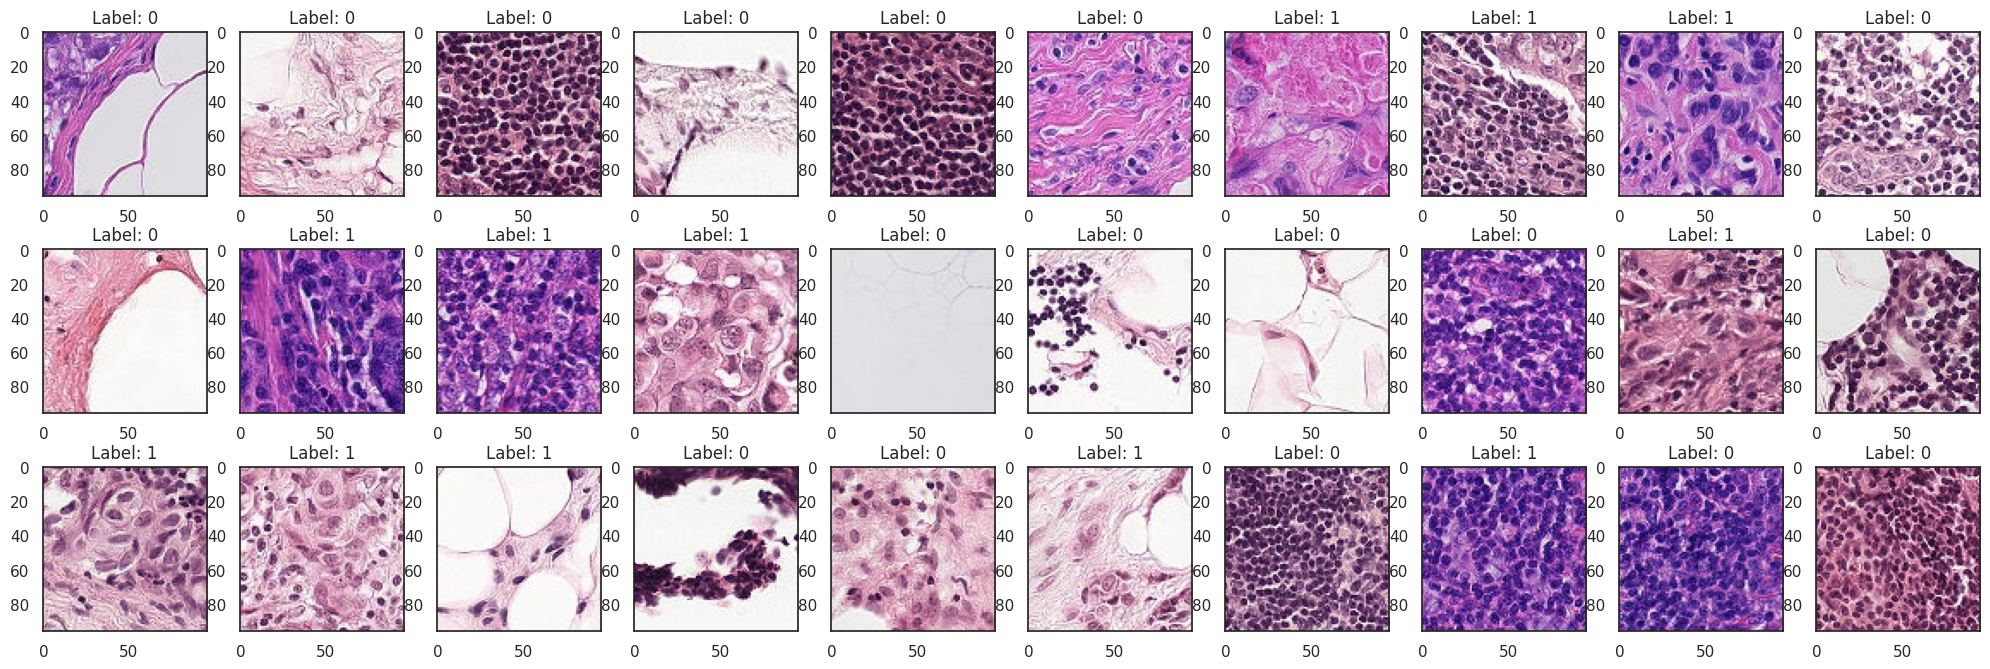

In [9]:
# create a figure with a size of 25 by 8 inches
fig = plt.figure(figsize=(25, 8))

# set the path to the training data folder
path2data = "data_sample/data_sample"


# get a list of all image files in the training data folder
train_imgs = os.listdir(path2data)

# loop over a randomly chosen subset of 30 images
for idx, img in enumerate(np.random.choice(train_imgs, 30)):

    # add a subplot to the figure
    # specify that there will be 3 rows and 10 columns of subplots
    ax = fig.add_subplot(3, 30//3, idx+1)

    # open the current image file
    im = Image.open(path2data + "/" + img)

    # display the image in the current subplot
    plt.imshow(im)

    # extract the label for the current image from a DataFrame
    # that has a column of image ids and their corresponding labels
    lab = labels_df.loc[labels_df["id"] == img.split('.')[0], 'label'].values[0]

    # set the title of the current subplot to the image label
    ax.set_title(f'Label: {lab}')


## Data Preparation


<div class="alert alert-block alert-info">

We'll create a `cancer_dataset` class for loading images and their corresponding labels for a binary classification task using PyTorch.

</div>    
    
The class `cancer_dataset` inherits from the `Dataset` class provided by PyTorch and overrides the `__init__`, `__len__`, and `__getitem__` methods.

- In the `__init__` method, the constructor takes in the directory path to the data, the desired image transformations to be applied, and the data type ("data_sample" by default). The method initializes a list of filenames of images present in the directory, obtains the full path to the images, and reads the labels from the 'labels.csv' file in the same directory. The image filenames without their extension (.png) are used to obtain their corresponding labels from the dataframe. The `self.labels` attribute is then populated with the labels for each image.

- In the `__len__` method, the number of images in the dataset is returned by taking the length of the `full_filenames` attribute.

- In the `__getitem__` method, given an index `idx`, the method opens the image at that index using the `Image.open` method from the Python Imaging Library (PIL), applies the image transformation using the `self.transform` attribute, and returns a tuple containing the transformed image and its corresponding label from the `self.labels` attribute.

This class can be used to create a PyTorch `DataLoader` to load `batches` of images during training or inference.
    


In [10]:
class cancer_dataset(Dataset):
  def __init__(self,data_dir,transform,dataset_type=None):
    path2data=os.path.join(data_dir,"data_sample")
    filenames=os.listdir(path2data)
    self.full_filenames=[os.path.join(path2data,f)for f in filenames]
     # Load the labels from a CSV file
    path2labels="labels.csv" # Corrected path to labels.csv
    labels_df=pd.read_csv(path2labels)
    labels_df.set_index("id",inplace=True)
     # Obtain the labels for the dataset
    if dataset_type=="train":
    # Only use a subset of the images for training
     self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames][0:3608]
     self.full_filenames=[os.path.join(path2data,f)for f in filenames][0:2608]
     print("Training dataset")
    elif dataset_type=="val":
            # Only use a subset of the images for validation
            self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames][3608:3648]
            self.full_filenames = [os.path.join(path2data, f) for f in filenames][3508:3648]
            print("validation dataset")

    elif dataset_type=="test":
            # Only use a subset of the images for testing
            self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames][3648:-1]
            self.full_filenames = [os.path.join(path2data, f) for f in filenames][3648:-1]
            print("testing dataset")

    else:
            # Use all the images for the dataset
            self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]

        # Save the data transformation to be applied to each image
    self.transform = transform
  def __len__(self):
            # Return the size of the dataset (i.e., the number of images)

    return len(self.full_filenames)
  def __getitem__(self,idx):
    img=Image.open(self.full_filenames[idx])
    img=self.transform(img)
    return img,self.labels[idx]

###  Transform the Dataset

Now you might be thinking, won't the model only be trained to recognize those exact images with this dataset?

This is where image preprocessing comes in. We want to train the model with more data. One way to do this is to create copies of the image and transform those copies. This process helps the model recognize an object rather than only the picture itself. For example, we can vertically flip an image. The object in the image does not change. If we rotate that image by 5 degrees, the object in the image does not change either.

To do this with our dataset, we'll create a transformation process called "composed". This will create copies of the images that are resized, horizontally flipped and rotated. We'll also convert the images to a tensor and normalize its image channels.


We will create transformers to convert PIL image to PyTorch tensors


In [11]:
import torchvision.transforms as transforms
#data transformation
mean=[0.485,0.456,0.406]
std=[0.229,0.244,0.225]
composed_train=transforms.Compose([
                               transforms.Resize((224, 224)),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomRotation(degrees=5),
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std)
])
composed=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [12]:
import os
from os import listdir
from os.path import isfile,join
mypath="data_sample/data_sample"
onlyfiles=[f for f in listdir(mypath) if isfile(join(mypath,f))]

In [13]:
labels_df

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


In [14]:
data_dir="data_sample"
dataset_full=cancer_dataset(data_dir,transform=composed)

In [15]:
img,label=dataset_full [19]
print(img.shape,torch.min(img),torch.max(img))

torch.Size([3, 224, 224]) tensor(-0.6956) tensor(2.6400)


### Splitting the Dataset


Let's split this training dataset into three separate parts: training, validation and testing. You might be wondering, why do we split the dataset like this?

Think of it this way: the training set is similar to practice questions offered in school. They help you learn and get better at answering the questions. The validation set is similar to a midterm, used to confirm your knowledge and offer you feedback on how you're performing so far. Finally, the testing set is similar to a final exam. It tests you on how well you perform after the entire learning process when faced with questions that you may have never seen before.

To train the model, we'll be using data from the first portion of the training dataset. To valdiate that data by calculating metrics such as validation loss, we'll use data from the second portion of the dataset. Finally, we'll test the model with the third portion of the dataset by using images it hasn't seen before.

Below, we're using 70% of our dataset for training, 15% for validation and the remaining 15% for testing. When we built our dataset class we included the as one of the parameters


In [16]:
training_set=cancer_dataset(data_dir,transform=composed_train,dataset_type="train")

validation_set=cancer_dataset(data_dir,transform=composed,dataset_type="val")

test_set=cancer_dataset(data_dir , transform=composed,dataset_type="test")
print(f'training dataset length: {len(training_set)}')
print(f'validation dataset length: {len(validation_set)}')
print(f'test dataset length: {len(test_set)}')


Training dataset
validation dataset
testing dataset
training dataset length: 2608
validation dataset length: 140
test dataset length: 360


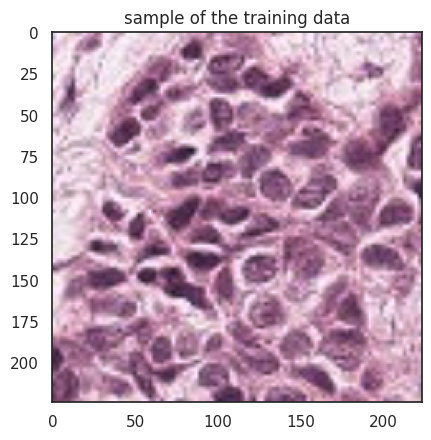

In [17]:
for i in range(5):
    plt.title("sample of the training data")
    imshow(training_set[2][0])

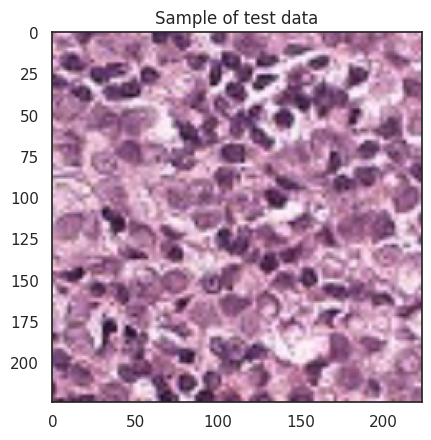

In [18]:
plt.title("Sample of test data")
imshow(test_set[0][0])

### Pytorch DataLoader
PyTorch DataLoader is a utility that helps to load and iterate over a dataset during the training and evaluation of deep learning models. It provides an iterable interface to the dataset and performs multi-process loading of data, which improves the data loading speed, especially when the data is stored on disk or in a remote location.

A DataLoader can shuffle the data before each epoch, apply transformations to the data, and combine multiple batches of data into a single batch. The batch size and the number of worker processes that load the data can be configured, which can help to optimize the memory usage and loading speed of the data. The PyTorch DataLoader is a flexible and efficient way to handle large datasets, and it is commonly used in deep learning projects.


In [19]:
# Load data
train_loader=torch.utils.data.DataLoader(dataset=training_set,batch_size=16,shuffle=True)
val_loader=torch.utils.data.DataLoader(dataset=validation_set,batch_size=16,shuffle=False)
test_loader=torch.utils.data.DataLoader(dataset=test_set,batch_size=16,shuffle=False)
#define classes
num_classes=2
print("Done")

Done


### Set Your Hyperparameters

Hyperparameters are important settings that can greatly affect the performance of a machine learning model. Common hyperparameters include batch size and learning rate, which can be adjusted to find the most optimal values for the model. Tuning these hyperparameters is typically a time-consuming and iterative process, but in this case, we've already taken care of that for you!

For this particular model, we have set the batch size, learning rate, and number of epochs to predetermined values. The batch size refers to the number of sample images that are used in one iteration of training the model, while the learning rate determines how much the model will change between iterations. The number of epochs indicates the number of times that the model will be trained on the entire dataset.Hyperparameters are important settings that can greatly affect the performance of a machine learning model. Common hyperparameters include batch size and learning rate, which can be adjusted to find the most optimal values for the model. Tuning these hyperparameters is typically a time-consuming and iterative process, but in this case, we've already taken care of that for you!

For this particular model, we have set the batch size, learning rate, and number of epochs to predetermined values. The batch size refers to the number of sample images that are used in one iteration of training the model, while the learning rate determines how much the model will change between iterations. The number of epochs indicates the number of times that the model will be trained on the entire dataset.


In [20]:
batch_size=30
lr=3e-4
n_epochs=5

### Load Your Model

Let's begin to define our model by loading it. For this lab, we'll be using the pre-trained model, ResNet34, a state-of-the-art image classification network by Microsoft. To load this model, we'll be using the following code, with the parameter `pretrained` set to `True`.


In [21]:
from torchvision import models
model=models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 145MB/s]


The original network was designed for classifying the image to 1,000 different classes. In our case, we only have 2 classes. For that reason, we'll replace the final layer to reduce the number of neurons from 1,000 to 2. Consequently, we'll need to retrain the final layer. To achieve this, we'll `freeze` the existing model parameters and replace the final layer.


## Search for the Optimal Model

With your toolkit assembled, tools prepared and model loaded, it's now time to put them to use by embarking on a journey to search for the optimal parameters. This will result in a model that will ideally have a high accuracy, meaning that it will more often than not detect when an image is a cancer or not a cancer correctly.

To search for the optimal parameters, we must first define a metric to measure what is optimal. In machine learning, this is done by defining a loss function. A more optimized model will have a lower loss. Since this neural network is designed to perform classification tasks, cross entropy loss (a loss function) becomes the natural choice to construct the model.


In [22]:
from torch.nn import CrossEntropyLoss
criterion=CrossEntropyLoss()

In [23]:
from torch.optim import Adam
optimizer=Adam(model.parameters(),lr=lr)

By freezing the parameters, we ensure that the pre-trained weights are not updated during the training process. Instead, we only update the parameters of the newly added layers or the layers that are not frozen. This allows us to reuse the knowledge that the pre-trained model has learned while training the new layers on a new task.

Now that we have everything we need to train the model, we can set up our training framework:


In [24]:
num_classes=2
model=models.resnet34(pretrained=True)
for param in model.parameters():
  #freezing layers
  param.requires_grad=False
  #modifying last layer
  num_ftrs=model.fc.in_features
  model.fc=nn.Linear(num_ftrs,num_classes)

## Train and Test the Model
Next, we train the model by looping through the training dataset and train the model for one epoch (one pass through the dataset). _We select one epoch due to limitation in computational power_

During each epoch, it calculates the loss between the model's predicted output and the true output labels, computes the gradients of the loss with respect to the model parameters, updates the parameters using the optimizer, and tracks the average loss over time. It also prints the average loss every 100 iterations of the training loop to provide some indication of the model's training progress. Overall, the code implements the basic training procedure for a PyTorch machine learning model.


In [27]:
# Train model

for epoch in range(1): # Loop over a single epoch
    running_loss = 0.0 # Initialize variable to track loss

    # Loop over the training data using a PyTorch DataLoader
    for i, data in enumerate(tqdm(train_loader)):
        # Extract inputs and labels from the data
        inputs, labels = data

        # Zero out the gradients in the optimizer
        optimizer.zero_grad()

        # Forward pass through the model
        outputs = model(inputs)

        # Calculate the loss between the model outputs and labels
        loss = criterion(outputs, labels)

        # Backpropagate the loss and compute gradients
        loss.backward()

        # Update the model parameters using the optimizer
        optimizer.step()

        # Update the running loss with the current batch loss
        running_loss += loss.item()


        # Print the average loss every 100 iterations
        if i % 100 == 99:
            tqdm.write('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0 # Reset running loss for the next 100 iterations
print("Training Finished..!")


 61%|██████▏   | 100/163 [03:52<02:18,  2.19s/it]

[1,   100] loss: 0.757


100%|██████████| 163/163 [06:13<00:00,  2.29s/it]


Lastly, we test the performance.
The code below loops through the test dataset, and for each batch of test data, it uses the model to make predictions on the input images, and then compares those predictions to the true labels. It keeps track of the total number of images seen, as well as the number of correctly classified images. After iterating over the entire test dataset, it calculates the accuracy of the model on the test set by dividing the number of correctly classified images by the total number of images, and printing the result as a percentage.



In [29]:
# Test the model
correct = 0 # Initialize variable to keep track of correctly classified images
total = 0 # Initialize variable to keep track of total images

# Use the model for inference, and disable gradient tracking
with torch.no_grad():
    for data in tqdm(test_loader): # Loop over the test data using a PyTorch DataLoader
        images, labels = data # Extract images and labels from the data

        # Forward pass through the model to obtain predictions
        outputs = model(images)

        # Find the predicted classes from the model's outputs
        # by taking the class with the highest score
        _, predicted = torch.max(outputs.data, 1)

        # Update the total count of images seen
        total += labels.size(0)

        # Update the count of correctly classified images
        correct += (predicted == labels).sum().item()

# Compute and print the model's accuracy on the test set
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))


100%|██████████| 23/23 [00:50<00:00,  2.20s/it]

Accuracy of the network on the test images: 49 %
